# Полносвязные нейронные сети с помощью `nn.Module`

In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы.

In [2]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128
train_dataloader =  DataLoader(train_dataset, batch_size, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size, drop_last=True)

Создадим функцию активации, которая ничего не делает:

In [3]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [4]:
features = 784
classes = 10
input_size = 128

model = nn.Sequential(
    nn.Flatten(),
    # hidden layers
    nn.Linear(features, input_size),
    nn.ELU(),
    nn.Linear(input_size, input_size),
    nn.ELU(),
    # output layer
    nn.Linear(input_size, classes),
)

In [5]:
# TODO Выберите функцию потерь
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device = torch.device('cpu')
device

device(type='cpu')

### Train loop

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [7]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # TODO установите режим ``train`` для модели
                # и вычислите выходы, не забудьте zero_grad!
                model.train()
                optimizer.zero_grad()
                output = model(x_batch)
            else:
                # TODO установите режим ``eval`` для модели 
                # вычислите выходы
                model.eval()
                output = model(x_batch)
            preds = output.argmax(-1)
            # TODO посчитайте количество верных ответов сети
            correct = sum(preds == y_batch) 
            # TODO общее количество элементов в батче
            all = len(output)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                # TODO вычислите градиенты 
                # и выполните шаг оптимизатора
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8796407585470085
Loader: valid. Accuracy: 0.9250801282051282
Epoch: 2
Loader: train. Accuracy: 0.9415898771367521
Loader: valid. Accuracy: 0.9496193910256411
Epoch: 3
Loader: train. Accuracy: 0.9583667200854701
Loader: valid. Accuracy: 0.9548277243589743
Epoch: 4
Loader: train. Accuracy: 0.9675313835470085
Loader: valid. Accuracy: 0.9619391025641025
Epoch: 5
Loader: train. Accuracy: 0.9747262286324786
Loader: valid. Accuracy: 0.9607371794871795
Epoch: 6
Loader: train. Accuracy: 0.9790665064102564
Loader: valid. Accuracy: 0.9631410256410257
Epoch: 7
Loader: train. Accuracy: 0.9822883279914529
Loader: valid. Accuracy: 0.9660456730769231
Epoch: 8
Loader: train. Accuracy: 0.9848424145299145
Loader: valid. Accuracy: 0.9670472756410257
Epoch: 9
Loader: train. Accuracy: 0.9847255608974359
Loader: valid. Accuracy: 0.9657451923076923
Epoch: 10
Loader: train. Accuracy: 0.9856103098290598
Loader: valid. Accuracy: 0.9706530448717948


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [8]:
# Сохраним найденные значения для функции активации ELU
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9250801282051282,
 0.9496193910256411,
 0.9548277243589743,
 0.9619391025641025,
 0.9607371794871795,
 0.9631410256410257,
 0.9660456730769231,
 0.9670472756410257,
 0.9657451923076923,
 0.9706530448717948]

Вычислите accuracy для других функций активации.

Удобнее обернуть создание и обучение модели в общую функцию с параметром activation

Данная функция должна возвращать массив accuracy по эпохам (accuracy["valid"])

In [9]:
def create_model(
    activation,
    features=784,
    classes=10,
    input_size=128
) -> nn.Sequential:
    model = nn.Sequential(
        nn.Flatten(),
        # hidden layers
        nn.Linear(features, input_size),
        activation(),
        nn.Linear(input_size, input_size),
        activation(),
        # output layer
        nn.Linear(input_size, classes),
    )
    return model


def teach_model(
    model: nn.Sequential,
    optimizer: torch.optim.Adam,
    criterion,
    max_epochs=10,
    debug: bool = False
) -> dict[str: list[float]]:
    accuracies = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    output = model(x_batch)
                else:
                    model.eval()
                    output = model(x_batch)
                preds = output.argmax(-1)
                correct = sum(preds == y_batch)
                all = len(output)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(output, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                if debug:
                    print(f"Epoch: {epoch + 1}")
            if debug:
                print(
                    f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}",
                    end='\n\n'
                )
            accuracies[k].append(
                epoch_correct / epoch_all
            )
    return accuracies


def test_activation_function(
    activation,
    criterion=nn.CrossEntropyLoss()
) -> dict[str: list[float]]:
    model = create_model(activation)
    optimizer = torch.optim.Adam(model.parameters())
    accuracies = teach_model(model, optimizer, criterion)
    return accuracies

In [10]:
criterion = nn.CrossEntropyLoss()

loaders = {
    "train": train_dataloader,
    "valid": valid_dataloader
}

plain_accuracies = test_activation_function(Identical)
relu_accuracies = test_activation_function(nn.ReLU)
leaky_relu_accuracies = test_activation_function(nn.LeakyReLU)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

In [11]:
def plot_graph(
    x,
    label_data: dict[str: list[float]],
    xlabel: str = 'Epoch'
) -> None:
    sns.set(style="darkgrid", font_scale=1.4)
    plt.figure(figsize=(16, 10))
    
    for label, elem in label_data.items():
        plt.plot(
            x,
            elem,
            label=label,
            linewidth=2
        )
    plt.legend()
    plt.xlabel(xlabel)
    plt.show()

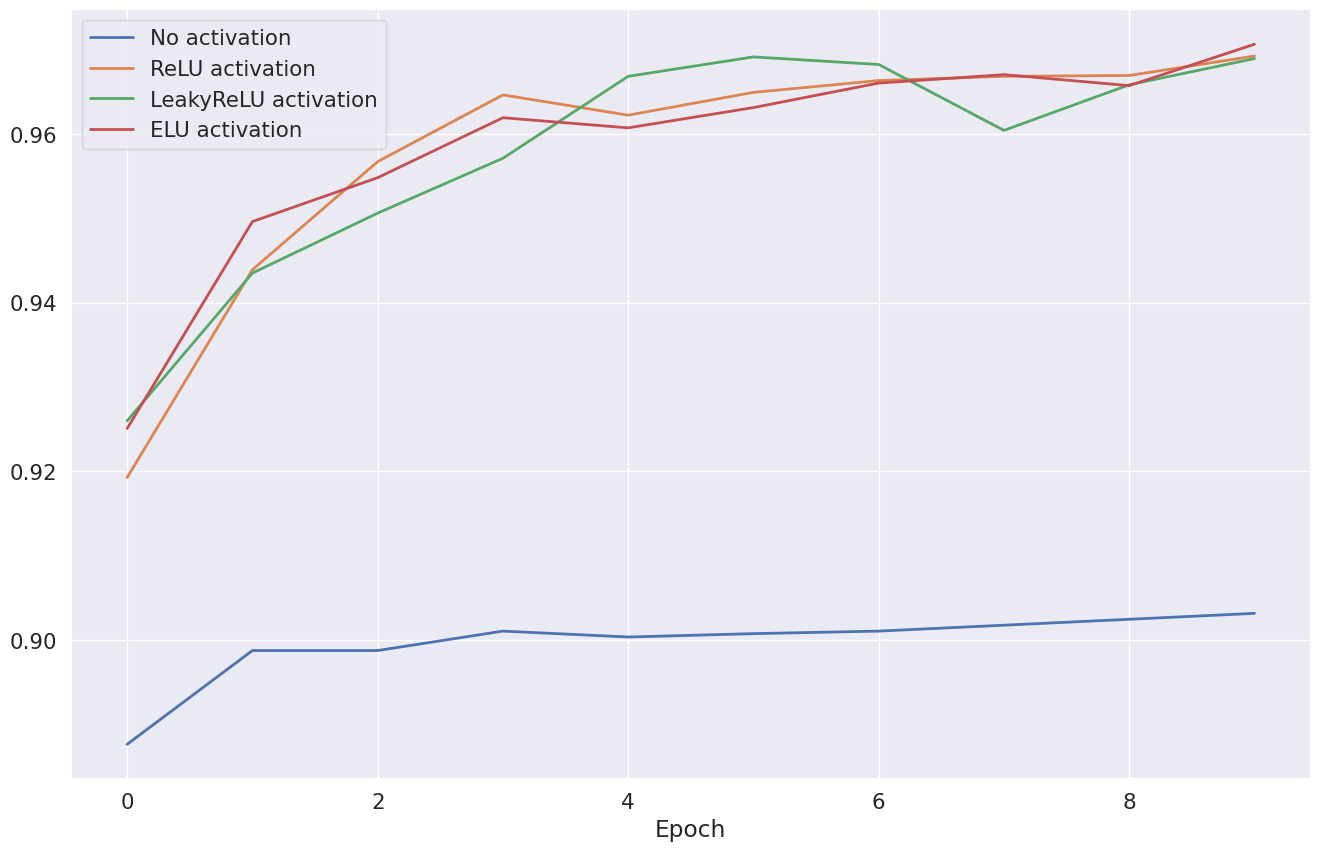

In [12]:
plot_graph(
    range(max_epochs),
    {
        'No activation': plain_accuracies['valid'],
        'ReLU activation': relu_accuracies['valid'],
        'LeakyReLU activation': leaky_relu_accuracies['valid'],
        'ELU activation': elu_accuracy
    }
)

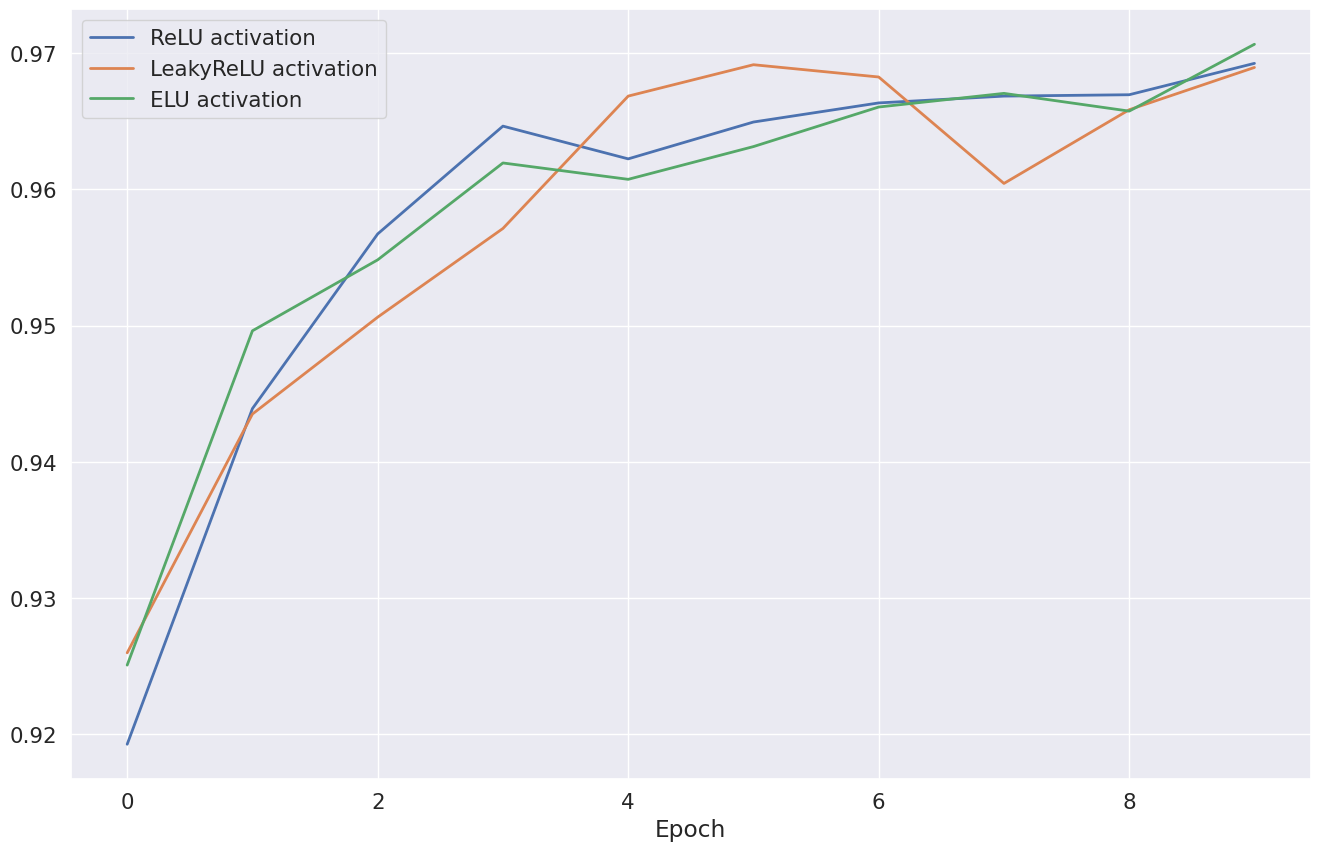

In [13]:
plot_graph(
    range(max_epochs),
    {
        'ReLU activation': relu_accuracies['valid'],
        'LeakyReLU activation': leaky_relu_accuracies['valid'],
        'ELU activation': elu_accuracy
    }
)

Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ELU**